# Clustering — Model Building, Interpretation & Evaluation
Following CRISP-DM Phases 4 (Modelling) and 5 (Evaluation)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score, adjusted_rand_score
from sklearn.decomposition import PCA
from scipy.stats import chi2_contingency
import scipy.cluster.hierarchy as sch
import warnings
warnings.filterwarnings('ignore')

# Load pre-constructed clustering features (single dataset with all 8 features)
df = pd.read_csv('data/clustering_features.csv')

# Load target variable from raw dataset
df_raw = pd.read_csv('CDC Diabetes Dataset (4).csv')
target = df_raw['Diabetes_012'].values

# 6 features — cardio_metabolic_risk and bmi_category dropped after sensitivity
# analysis showed removing them improves cluster quality while retaining diabetes separation
features = ['lifestyle_risk_score', 'limited_access_to_care', 'age_group',
            'income_bracket', 'education_bracket', 'perceived_health_risk']

print(f"Dataset loaded: {df.shape[0]:,} records, {df.shape[1]} total features")
print(f"Features dropped for final model: {[c for c in df.columns if c not in features]}")
print(f"Features used: {len(features)}")
print(f"Target: {len(target):,} records")
print(f"\nFeature ranges:")
for col in features:
    print(f"  {col}: {df[col].min()}–{df[col].max()}")

Dataset loaded: 253,680 records, 8 total features
Features dropped for final model: ['cardio_metabolic_risk', 'bmi_category']
Features used: 6
Target: 253,680 records

Feature ranges:
  lifestyle_risk_score: 0–5
  limited_access_to_care: 0–1
  age_group: 0–3
  income_bracket: 0–2
  education_bracket: 0–2
  perceived_health_risk: 0–4


## 4.1 Select Modelling Technique

K-Means was selected as the primary algorithm for its interpretable centroids and fixed segment count. Although ordinal features violate the Euclidean distance assumption, engineered features partially mitigate this (clinically meaningful binning, near-continuous composites). The solution is triangulated against Hierarchical (Ward), DBSCAN, and Gower-distance clustering.

| Algorithm | Distance Metric | Purpose |
|-----------|-----------------|---------|
| K-Means | Euclidean | Primary — interpretable centroids |
| Hierarchical (Ward) | Euclidean | Hierarchy visualisation, k validation |
| DBSCAN | Euclidean | Density-based validation |
| Hierarchical (Gower) | Gower | Ordinal-appropriate validation |

### Clustering Feature Set (6 features)

| Feature | Type | Range | Domain |
|---------|------|-------|--------|
| lifestyle_risk_score | Ordinal | 0–5 | Behavioural |
| limited_access_to_care | Binary | 0–1 | Access |
| age_group | Ordinal | 0–3 | Demographic |
| income_bracket | Ordinal | 0–2 | Socioeconomic |
| education_bracket | Ordinal | 0–2 | Socioeconomic |
| perceived_health_risk | Ordinal | 0–4 | Self-reported health |

Clinical/anthropometric features (`cardio_metabolic_risk`, `bmi_category`) were excluded after sensitivity analysis — they degraded cluster quality without meaningfully improving diabetes stratification.

## 4.2 Generate Test Design

Since clustering is unsupervised, evaluation relies on:
- **Internal metrics**: Silhouette score, Davies-Bouldin index, inertia (elbow method)
- **Robustness**: Adjusted Rand Index (ARI) across algorithms
- **External consistency**: Post-hoc diabetes prevalence comparison (not used for model selection)
- **Visualisation**: PCA for cluster structure

A 10% sample (~25,368 records) is used for k-selection and silhouette calculation; the full dataset for the final model.

In [2]:
# Preprocessing and sampling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

np.random.seed(42)
sample_idx = np.random.choice(len(df), int(len(df) * 0.10), replace=False)
X_sample = X_scaled[sample_idx]
df_sample = df.iloc[sample_idx].copy()

print(f"Full dataset: {len(df):,} records")
print(f"Sample (10%): {len(X_sample):,} records")

Full dataset: 253,680 records
Sample (10%): 25,368 records


## 4.3 Build Model

### 4.3.1 Parameter Settings — K Selection

K is selected using internal validation metrics only. Diabetes outcomes are excluded from k-selection to avoid target leakage.

In [3]:
# Evaluate k=2 to 8 using internal metrics only
k_range = range(2, 9)
results = {'k': [], 'inertia': [], 'silhouette': [], 'davies_bouldin': []}

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_sample)
    results['k'].append(k)
    results['inertia'].append(km.inertia_)
    results['silhouette'].append(silhouette_score(X_sample, labels))
    results['davies_bouldin'].append(davies_bouldin_score(X_sample, labels))

results_df = pd.DataFrame(results)
print(results_df.round(3).to_string(index=False))

 k    inertia  silhouette  davies_bouldin
 2 164827.298       0.233           1.976
 3 143254.011       0.226           1.780
 4 128189.003       0.171           1.787
 5 119598.970       0.149           1.765
 6 113273.701       0.151           1.802
 7 107894.037       0.146           1.774
 8 102908.144       0.149           1.796


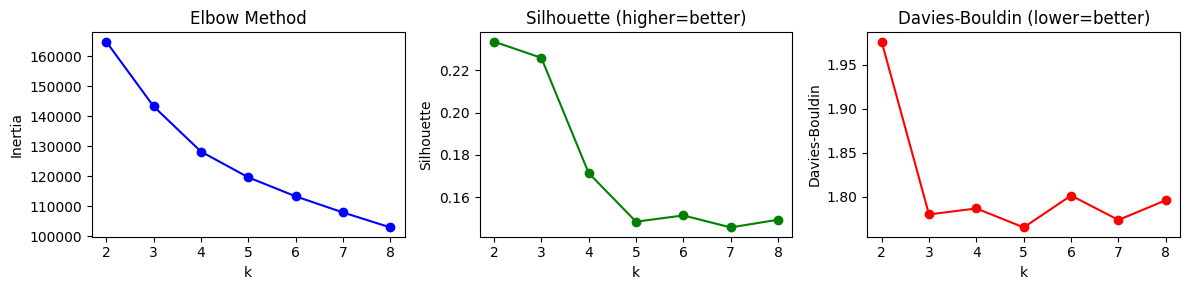

In [4]:
# Visualise k-selection
fig, axes = plt.subplots(1, 3, figsize=(12, 3))

axes[0].plot(k_range, results['inertia'], 'bo-')
axes[0].set_xlabel('k'); axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Method')

axes[1].plot(k_range, results['silhouette'], 'go-')
axes[1].set_xlabel('k'); axes[1].set_ylabel('Silhouette')
axes[1].set_title('Silhouette (higher=better)')

axes[2].plot(k_range, results['davies_bouldin'], 'ro-')
axes[2].set_xlabel('k'); axes[2].set_ylabel('Davies-Bouldin')
axes[2].set_title('Davies-Bouldin (lower=better)')

plt.tight_layout()
plt.savefig('figures/k_selection.png', dpi=150)
plt.show()

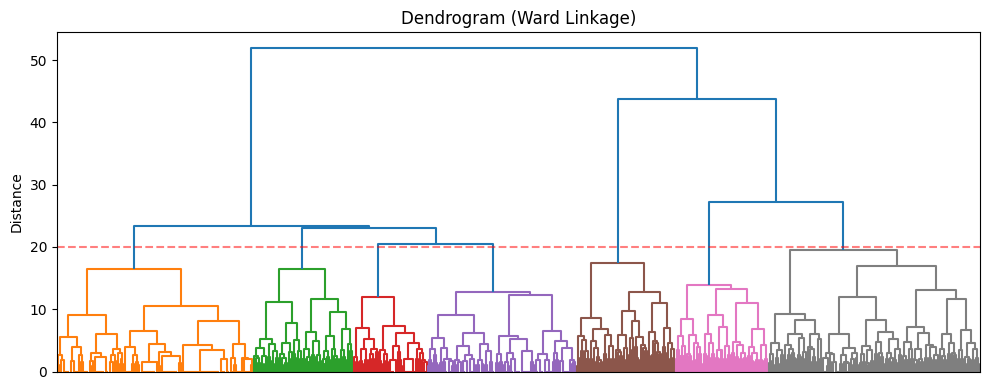

In [5]:
# Dendrogram for hierarchical perspective
dendro_idx = np.random.choice(len(X_sample), 1000, replace=False)
linkage_matrix = sch.linkage(X_sample[dendro_idx], method='ward')

fig, ax = plt.subplots(figsize=(10, 4))
sch.dendrogram(linkage_matrix, ax=ax, no_labels=True, color_threshold=20)
ax.set_title('Dendrogram (Ward Linkage)')
ax.set_ylabel('Distance')
ax.axhline(y=20, color='r', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('figures/dendrogram.png', dpi=150)
plt.show()

### Parameter Settings Decision

**Selected: k=3**

| Criterion | Observation |
|-----------|-------------|
| Elbow | Visible bend around k=3 |
| Silhouette | k=3 offers good trade-off between cluster quality and interpretability |
| Davies-Bouldin | k=3 shows acceptable cluster separation |
| Dendrogram | Cutting at distance ≈20 suggests 3 clusters |
| Interpretability | 3 segments are manageable for public health campaigns |

**K-Means parameters:** `n_clusters=3`, `n_init=10`, `random_state=42`

### 4.3.2 Final Model

In [6]:
CHOSEN_K = 3

final_model = Pipeline([
    ('scaler', StandardScaler()),
    ('kmeans', KMeans(n_clusters=CHOSEN_K, random_state=42, n_init=10))
])

# Fit on features only (not extra columns that may have been added)
df['cluster'] = final_model.fit_predict(df[features])

print(f"Final model fitted on {len(df):,} records")
print(f"\nCluster sizes:")
for c in range(CHOSEN_K):
    n = (df['cluster'] == c).sum()
    print(f"  Cluster {c}: {n:,} ({n/len(df)*100:.1f}%)")

Final model fitted on 253,680 records

Cluster sizes:
  Cluster 0: 156,906 (61.9%)
  Cluster 1: 29,192 (11.5%)
  Cluster 2: 67,582 (26.6%)


In [7]:
# Centroids (inverse-transformed for interpretation)
kmeans_model = final_model.named_steps['kmeans']
scaler_model = final_model.named_steps['scaler']
centroids_scaled = kmeans_model.cluster_centers_
centroids = scaler_model.inverse_transform(centroids_scaled)

centroids_df = pd.DataFrame(centroids, columns=features)
centroids_df.index.name = 'Cluster'
print("Cluster centroids (mean feature values):")
print(centroids_df.round(2))

Cluster centroids (mean feature values):
         lifestyle_risk_score  limited_access_to_care  age_group  \
Cluster                                                            
0                        0.97                    -0.0       1.39   
1                        1.55                     1.0       1.16   
2                        1.94                     0.0       1.97   

         income_bracket  education_bracket  perceived_health_risk  
Cluster                                                            
0                  1.88               1.86                   0.42  
1                  1.09               1.46                   1.42  
2                  0.87               1.21                   1.91  


### Model Description

K-Means partitions 253,680 respondents into 3 segments based on 6 non-clinical features spanning behavioural, access, demographic, socioeconomic, and self-reported health domains. Centroids represent the "average patient" in each cluster.

## 4.4 Assess Model

### 4.4.1 Algorithm Comparison

In [8]:
# Compare algorithms on 10% sample
km_labels = KMeans(n_clusters=CHOSEN_K, random_state=42, n_init=10).fit_predict(X_sample)
hier_labels = AgglomerativeClustering(n_clusters=CHOSEN_K, linkage='ward').fit_predict(X_sample)

# DBSCAN - auto-determines clusters based on density
dbscan = DBSCAN(eps=2.0, min_samples=50)
dbscan_labels = dbscan.fit_predict(X_sample)
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

# Gower distance — appropriate for mixed ordinal/binary features
# Uses range-normalised Manhattan distance for ordinal, simple matching for binary
# Computed on a 5,000-point subsample (O(n²) distance matrix)
np.random.seed(42)
gower_idx = np.random.choice(len(X_sample), 5000, replace=False)
X_gower_raw = df_sample[features].values[gower_idx]

# Ranges: lifestyle=5, access=0(binary), age=3, income=2, education=2, perceived=4
feature_ranges = np.array([5, 0, 3, 2, 2, 4], dtype=float)  # 0 = binary
n_gower = X_gower_raw.shape[0]
n_feat = X_gower_raw.shape[1]
D_gower = np.zeros((n_gower, n_gower))
for j in range(n_feat):
    col = X_gower_raw[:, j:j+1]
    if feature_ranges[j] == 0:  # binary feature
        D_gower += (col != col.T).astype(float)
    else:  # ordinal feature
        D_gower += np.abs(col - col.T) / feature_ranges[j]
D_gower /= n_feat

gower_hier = AgglomerativeClustering(n_clusters=CHOSEN_K, metric='precomputed', linkage='average')
gower_labels = gower_hier.fit_predict(D_gower)

# Get K-Means labels on same subsample for fair comparison
km_labels_sub = km_labels[gower_idx]

comparison = {
    'Algorithm': ['K-Means', 'Hierarchical (Ward)', 'DBSCAN', 'Hierarchical (Gower)'],
    'Silhouette': [
        silhouette_score(X_sample, km_labels),
        silhouette_score(X_sample, hier_labels),
        silhouette_score(X_sample, dbscan_labels) if n_clusters_dbscan > 1 else 0.0,
        silhouette_score(D_gower, gower_labels, metric='precomputed')
    ],
    'Davies-Bouldin': [
        davies_bouldin_score(X_sample, km_labels),
        davies_bouldin_score(X_sample, hier_labels),
        davies_bouldin_score(X_sample, dbscan_labels) if n_clusters_dbscan > 1 else np.nan,
        davies_bouldin_score(X_gower_raw, gower_labels)
    ],
    'N_Clusters': [CHOSEN_K, CHOSEN_K, n_clusters_dbscan, CHOSEN_K]
}

print(f"DBSCAN found {n_clusters_dbscan} clusters and {n_noise} noise points ({n_noise/len(X_sample)*100:.1f}%)")
print(f"Gower distance computed on {n_gower:,}-point subsample")
print()
print(pd.DataFrame(comparison).round(4).to_string(index=False))

DBSCAN found 2 clusters and 92 noise points (0.4%)
Gower distance computed on 5,000-point subsample

           Algorithm  Silhouette  Davies-Bouldin  N_Clusters
             K-Means      0.2258          1.7800           3
 Hierarchical (Ward)      0.1692          2.1348           3
              DBSCAN      0.2785          2.0598           2
Hierarchical (Gower)      0.4458          2.5279           3


In [9]:
# Algorithm agreement (Adjusted Rand Index)
print("Algorithm Agreement (ARI):")
print(f"  K-Means vs Hierarchical (Ward): {adjusted_rand_score(km_labels, hier_labels):.3f}")
print(f"  K-Means vs DBSCAN:              {adjusted_rand_score(km_labels, dbscan_labels):.3f}")
print(f"  K-Means vs Gower (subsample):   {adjusted_rand_score(km_labels_sub, gower_labels):.3f}")

print(f"\nNote: Gower comparison uses a 5,000-point subsample (O(n²) distance matrix)")
print(f"DBSCAN uses density-based clustering — low agreement is expected if natural structure differs from k={CHOSEN_K}")

Algorithm Agreement (ARI):
  K-Means vs Hierarchical (Ward): 0.453
  K-Means vs DBSCAN:              0.329
  K-Means vs Gower (subsample):   0.427

Note: Gower comparison uses a 5,000-point subsample (O(n²) distance matrix)
DBSCAN uses density-based clustering — low agreement is expected if natural structure differs from k=3


ARI comparisons show moderate agreement across algorithms, confirming the cluster structure is not purely an artefact of K-Means. Gower-distance clustering validates the structure under an ordinal-appropriate metric. K-Means is retained for its centroid interpretability and suitability for creating actionable patient segments.

### 4.4.2 Internal Validation

In [10]:
# Silhouette analysis on 10% sample
X_scaled_full = final_model.named_steps['scaler'].transform(df[features])
X_eval = X_scaled_full[sample_idx]
labels_eval = df['cluster'].values[sample_idx]

sil_avg = silhouette_score(X_eval, labels_eval)
sil_samples = silhouette_samples(X_eval, labels_eval)
db_score = davies_bouldin_score(X_eval, labels_eval)

print(f"Overall Metrics (10% sample, n={len(sample_idx):,}):")
print(f"  Silhouette Score: {sil_avg:.4f}")
print(f"  Davies-Bouldin Index: {db_score:.4f}")

print(f"\nPer-cluster Silhouette:")
for c in range(CHOSEN_K):
    cluster_sil = sil_samples[labels_eval == c].mean()
    n = (labels_eval == c).sum()
    print(f"  Cluster {c}: {cluster_sil:.4f} (n={n:,})")

Overall Metrics (10% sample, n=25,368):
  Silhouette Score: 0.3183
  Davies-Bouldin Index: 1.5035

Per-cluster Silhouette:
  Cluster 0: 0.4327 (n=15,690)
  Cluster 1: 0.2400 (n=2,923)
  Cluster 2: 0.0865 (n=6,755)


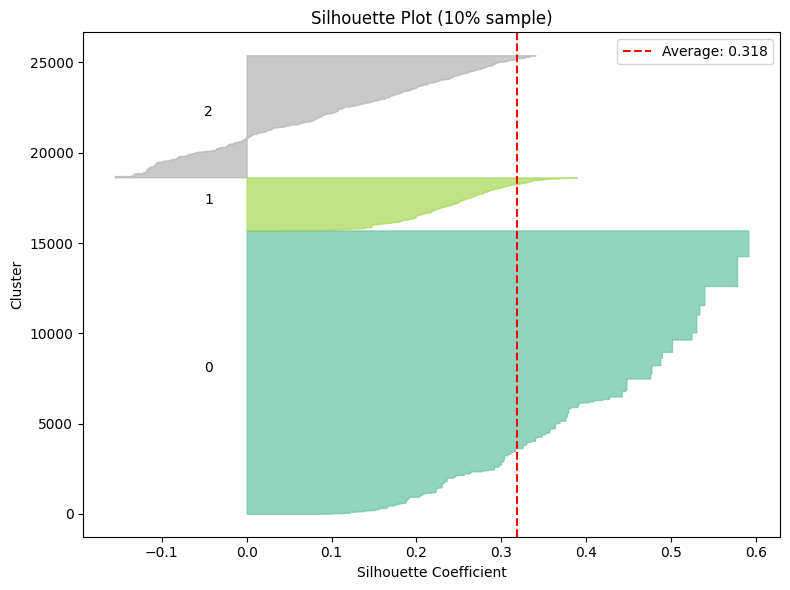

In [11]:
# Silhouette plot
fig, ax = plt.subplots(figsize=(8, 6))
y_lower = 10
colors = plt.cm.Set2(np.linspace(0, 1, CHOSEN_K))

for i in range(CHOSEN_K):
    cluster_sil = sil_samples[labels_eval == i]
    cluster_sil.sort()
    y_upper = y_lower + len(cluster_sil)
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_sil,
                     alpha=0.7, color=colors[i])
    ax.text(-0.05, y_lower + 0.5 * len(cluster_sil), str(i))
    y_lower = y_upper + 10

ax.axvline(x=sil_avg, color='red', linestyle='--', label=f'Average: {sil_avg:.3f}')
ax.set_xlabel('Silhouette Coefficient')
ax.set_ylabel('Cluster')
ax.set_title('Silhouette Plot (10% sample)')
ax.legend()
plt.tight_layout()
plt.savefig('figures/silhouette_plot.png', dpi=150)
plt.show()

Moderate silhouette and acceptable Davies-Bouldin scores indicate the clusters are cohesive and reasonably separated given the ordinal feature space. Per-cluster silhouette scores show uneven separation — consistent with a gradual health risk gradient rather than sharply defined groups.

### 4.4.3 External Validation: Diabetes Outcomes

Since diabetes was excluded from clustering, different diabetes rates across clusters serve as a consistency check. Note that `perceived_health_risk` (ρ ≈ 0.35 with diabetes) means some association is expected mechanistically — this validation is a consistency check, not independent evidence of predictive power.

In [12]:
# Cluster profiles
profiles = df.groupby('cluster')[features].mean()
profiles['n'] = df.groupby('cluster').size()
profiles['%'] = (profiles['n'] / len(df) * 100).round(1)

print("Cluster Profiles (mean feature values):")
print(profiles.round(2))

Cluster Profiles (mean feature values):
         lifestyle_risk_score  limited_access_to_care  age_group  \
cluster                                                            
0                        0.97                     0.0       1.39   
1                        1.55                     1.0       1.16   
2                        1.94                     0.0       1.97   

         income_bracket  education_bracket  perceived_health_risk       n  \
cluster                                                                     
0                  1.88               1.86                   0.42  156906   
1                  1.09               1.46                   1.42   29192   
2                  0.87               1.21                   1.91   67582   

            %  
cluster        
0        61.9  
1        11.5  
2        26.6  


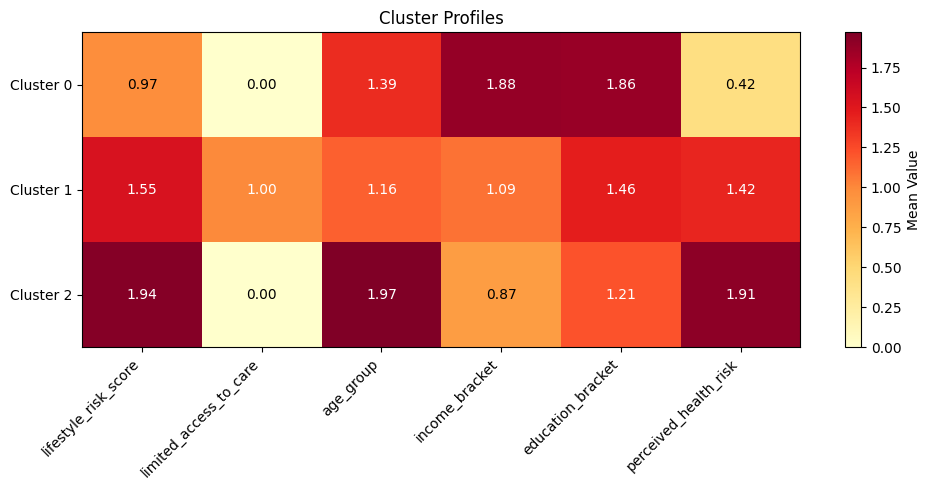

In [13]:
# Heatmap visualisation
fig, ax = plt.subplots(figsize=(10, 5))
im = ax.imshow(profiles[features].values, cmap='YlOrRd', aspect='auto')

ax.set_xticks(range(len(features)))
ax.set_yticks(range(len(profiles)))
ax.set_xticklabels(features, rotation=45, ha='right')
ax.set_yticklabels([f'Cluster {i}' for i in profiles.index])

for i in range(len(profiles)):
    for j in range(len(features)):
        val = profiles[features].iloc[i, j]
        ax.text(j, i, f'{val:.2f}', ha='center', va='center',
                color='white' if val > profiles[features].values.max()/2 else 'black')

plt.colorbar(im, label='Mean Value')
ax.set_title('Cluster Profiles')
plt.tight_layout()
plt.savefig('figures/cluster_profiles.png', dpi=150)
plt.show()

In [14]:
# Diabetes rates by cluster
df['Diabetes_012'] = target
diabetes_rates = pd.crosstab(df['cluster'], df['Diabetes_012'], normalize='index')
diabetes_rates.columns = ['No Diabetes', 'Prediabetes', 'Diabetes']

print("Diabetes prevalence by cluster:")
print(diabetes_rates.round(3))

print(f"\nDiabetes rate range: {diabetes_rates['Diabetes'].min()*100:.1f}% to {diabetes_rates['Diabetes'].max()*100:.1f}%")
print(f"Spread: {(diabetes_rates['Diabetes'].max() - diabetes_rates['Diabetes'].min())*100:.1f} percentage points")

Diabetes prevalence by cluster:
         No Diabetes  Prediabetes  Diabetes
cluster                                    
0              0.901        0.013     0.086
1              0.820        0.024     0.156
2              0.716        0.028     0.256

Diabetes rate range: 8.6% to 25.6%
Spread: 17.0 percentage points


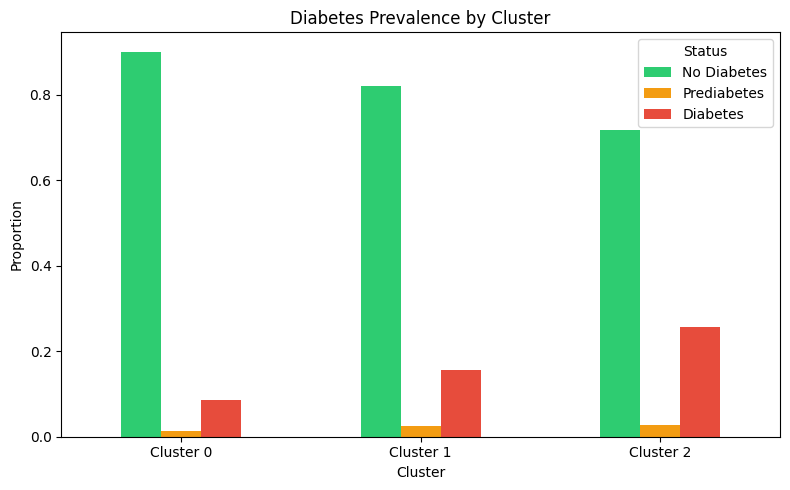

In [15]:
fig, ax = plt.subplots(figsize=(8, 5))
diabetes_rates.plot(kind='bar', ax=ax, color=['#2ecc71', '#f39c12', '#e74c3c'])
ax.set_xlabel('Cluster')
ax.set_ylabel('Proportion')
ax.set_title('Diabetes Prevalence by Cluster')
ax.set_xticklabels([f'Cluster {i}' for i in diabetes_rates.index], rotation=0)
ax.legend(title='Status')
plt.tight_layout()
plt.savefig('figures/diabetes_by_cluster.png', dpi=150)
plt.show()

In [16]:
# Statistical test
contingency = pd.crosstab(df['cluster'], df['Diabetes_012'])
chi2, p_value, dof, expected = chi2_contingency(contingency)

print(f"Chi-square test for independence:")
print(f"  Chi-sq = {chi2:.2f}")
print(f"  df = {dof}")
print(f"  p-value = {p_value:.2e}")

Chi-square test for independence:
  Chi-sq = 12401.67
  df = 4
  p-value = 0.00e+00


The chi-square test confirms cluster membership and diabetes status are not independent (p < 0.001). Diabetes prevalence increases monotonically across clusters, supporting the clinical relevance of the segmentation. The 6-feature model has only one direct diabetes correlate, making this validation less circular than a model using clinical markers.

### 4.4.4 Sensitivity Analysis: Effect of Clinical/Anthropometric Features

To justify the 6-feature model, we compare cluster quality and diabetes stratification across three feature sets — progressively adding clinical and anthropometric features to show their effect on the trade-off between cluster quality and diabetes separation.

In [17]:
# Compare 6 vs 7 vs 8 feature models
features_7 = features + ['bmi_category']
features_8 = features + ['bmi_category', 'cardio_metabolic_risk']

print(f"6 features: {features}")
print(f"7 features: {features_7}  (+bmi_category)")
print(f"8 features: {features_8}  (+bmi_category, +cardio_metabolic_risk)")

# --- 7-feature model ---
model_7 = Pipeline([('scaler', StandardScaler()),
                     ('kmeans', KMeans(n_clusters=CHOSEN_K, random_state=42, n_init=10))])
labels_7 = model_7.fit_predict(df[features_7])

X_7_eval = model_7.named_steps['scaler'].transform(df[features_7])[sample_idx]
labels_7_eval = labels_7[sample_idx]
sil_7 = silhouette_score(X_7_eval, labels_7_eval)
db_7 = davies_bouldin_score(X_7_eval, labels_7_eval)

rates_7 = pd.crosstab(pd.Series(labels_7), pd.Series(target), normalize='index')
rates_7.columns = ['No Diabetes', 'Prediabetes', 'Diabetes']
spread_7 = (rates_7['Diabetes'].max() - rates_7['Diabetes'].min()) * 100
chi2_7, _, _, _ = chi2_contingency(pd.crosstab(pd.Series(labels_7), pd.Series(target)))

# --- 8-feature model ---
model_8 = Pipeline([('scaler', StandardScaler()),
                     ('kmeans', KMeans(n_clusters=CHOSEN_K, random_state=42, n_init=10))])
labels_8 = model_8.fit_predict(df[features_8])

X_8_eval = model_8.named_steps['scaler'].transform(df[features_8])[sample_idx]
labels_8_eval = labels_8[sample_idx]
sil_8 = silhouette_score(X_8_eval, labels_8_eval)
db_8 = davies_bouldin_score(X_8_eval, labels_8_eval)

rates_8 = pd.crosstab(pd.Series(labels_8), pd.Series(target), normalize='index')
rates_8.columns = ['No Diabetes', 'Prediabetes', 'Diabetes']
spread_8 = (rates_8['Diabetes'].max() - rates_8['Diabetes'].min()) * 100
chi2_8, _, _, _ = chi2_contingency(pd.crosstab(pd.Series(labels_8), pd.Series(target)))

# --- Side-by-side comparison ---
spread_full = (diabetes_rates['Diabetes'].max() - diabetes_rates['Diabetes'].min()) * 100

print(f"\n{'Metric':<25} {'6 features':>12} {'7 (+BMI)':>12} {'8 (+both)':>12}")
print("-" * 61)
print(f"{'Silhouette ↑':<25} {sil_avg:>12.3f} {sil_7:>12.3f} {sil_8:>12.3f}")
print(f"{'Davies-Bouldin ↓':<25} {db_score:>12.3f} {db_7:>12.3f} {db_8:>12.3f}")
print(f"{'Diabetes spread (pp)':<25} {spread_full:>11.1f}pp {spread_7:>11.1f}pp {spread_8:>11.1f}pp")
print(f"{'Chi-square':<25} {chi2:>12,.0f} {chi2_7:>12,.0f} {chi2_8:>12,.0f}")

print(f"\n--- Per-cluster diabetes prevalence ---")
print(f"\n6 features (selected model):")
print(diabetes_rates.round(3))
print(f"\n7 features (+bmi_category):")
print(rates_7.round(3))
print(f"\n8 features (+bmi_category, +cardio_metabolic_risk):")
print(rates_8.round(3))

6 features: ['lifestyle_risk_score', 'limited_access_to_care', 'age_group', 'income_bracket', 'education_bracket', 'perceived_health_risk']
7 features: ['lifestyle_risk_score', 'limited_access_to_care', 'age_group', 'income_bracket', 'education_bracket', 'perceived_health_risk', 'bmi_category']  (+bmi_category)
8 features: ['lifestyle_risk_score', 'limited_access_to_care', 'age_group', 'income_bracket', 'education_bracket', 'perceived_health_risk', 'bmi_category', 'cardio_metabolic_risk']  (+bmi_category, +cardio_metabolic_risk)

Metric                      6 features     7 (+BMI)    8 (+both)
-------------------------------------------------------------
Silhouette ↑                     0.318        0.272        0.227
Davies-Bouldin ↓                 1.503        1.667        1.778
Diabetes spread (pp)             17.0pp        18.2pp        21.1pp
Chi-square                      12,402       13,942       20,697

--- Per-cluster diabetes prevalence ---

6 features (selected model):
   

| Feature Set | Added Features | Effect |
|-------------|---------------|--------|
| 6 features | — (selected model) | Best cluster quality |
| 7 features | + `bmi_category` | Slight diabetes improvement, cluster quality drops |
| 8 features | + `bmi_category`, `cardio_metabolic_risk` | Most diabetes separation, worst cluster quality |

The 6-feature model offers the best trade-off: cohesive clusters with sufficient diabetes stratification, defined by actionable non-clinical dimensions.

### 4.4.5 Dimensionality Reduction Visualisation

**PCA** (linear) is used to visualise the cluster structure in 2D:
- Preserves global variance structure
- Interpretable loadings show which features drive each axis
- Scree plot shows how variance is distributed across components

Variance explained:
  PC1: 32.6%
  PC2: 19.3%
  PC3: 14.4%
  PC4: 13.1%
  PC5: 11.2%
  PC6: 9.4%
  Total (2 components): 51.9%


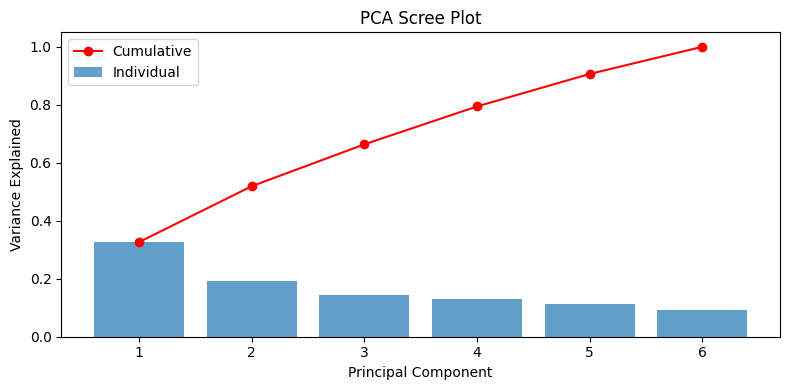

In [18]:
# PCA with all components for scree plot
pca_full = PCA(random_state=42)
pca_full.fit(X_scaled_full)

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled_full)

print(f"Variance explained:")
for i, var in enumerate(pca_full.explained_variance_ratio_):
    print(f"  PC{i+1}: {var:.1%}")
print(f"  Total (2 components): {sum(pca.explained_variance_ratio_):.1%}")

# Scree plot
fig, ax = plt.subplots(figsize=(8, 4))
cumulative = np.cumsum(pca_full.explained_variance_ratio_)
ax.bar(range(1, len(pca_full.explained_variance_ratio_)+1), 
       pca_full.explained_variance_ratio_, alpha=0.7, label='Individual')
ax.plot(range(1, len(cumulative)+1), cumulative, 'ro-', label='Cumulative')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Variance Explained')
ax.set_title('PCA Scree Plot')
ax.legend()
ax.set_xticks(range(1, len(pca_full.explained_variance_ratio_)+1))
plt.tight_layout()
plt.savefig('figures/pca_scree.png', dpi=150)
plt.show()

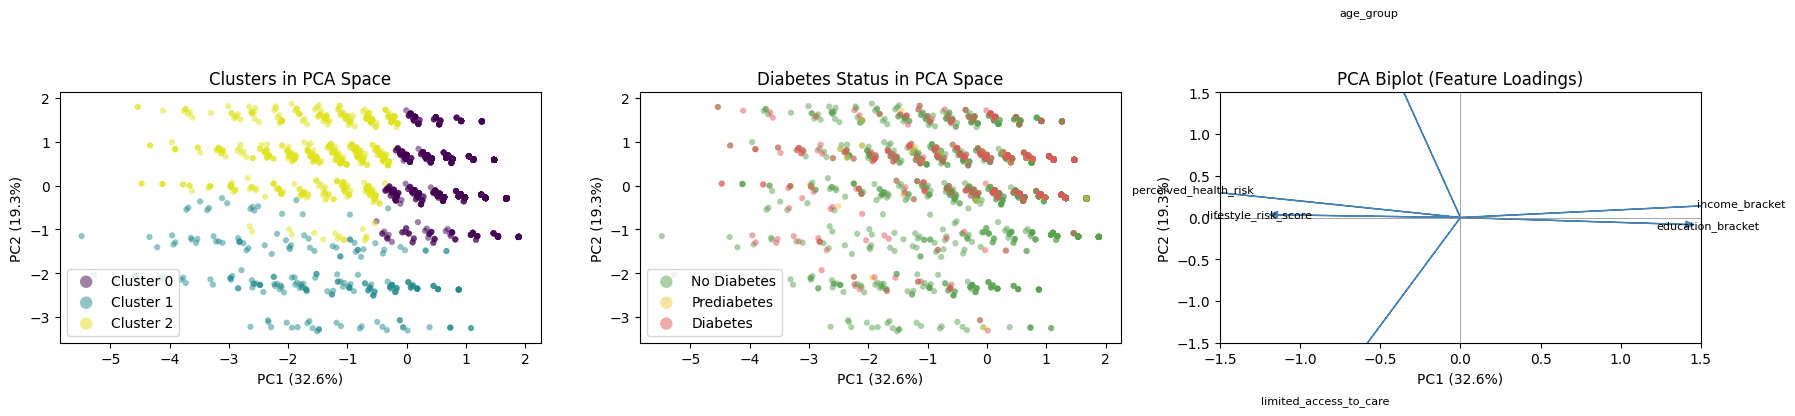

In [19]:
# Sample for clean visualisation
np.random.seed(42)
plot_idx = np.random.choice(len(df), 2000, replace=False)
X_pca_plot = X_pca[plot_idx]
labels_plot = df['cluster'].values[plot_idx]
diabetes_plot = df['Diabetes_012'].values[plot_idx]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Clusters in PCA space
cmap = plt.cm.viridis(np.linspace(0, 0.95, CHOSEN_K))
for c in range(CHOSEN_K):
    mask = labels_plot == c
    axes[0].scatter(X_pca_plot[mask, 0], X_pca_plot[mask, 1],
                    s=20, alpha=0.5, color=cmap[c], label=f'Cluster {c}',
                    edgecolors='none')
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
axes[0].set_title('Clusters in PCA Space')
axes[0].legend(markerscale=2)

# Diabetes status in PCA space
colors_diab = {0: '#59a14f', 1: '#edc948', 2: '#e15759'}
names_diab = {0: 'No Diabetes', 1: 'Prediabetes', 2: 'Diabetes'}
for status in [0, 1, 2]:
    mask = diabetes_plot == status
    axes[1].scatter(X_pca_plot[mask, 0], X_pca_plot[mask, 1],
                    s=20, alpha=0.5, color=colors_diab[status],
                    label=names_diab[status], edgecolors='none')
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
axes[1].set_title('Diabetes Status in PCA Space')
axes[1].legend(markerscale=2)

# PCA biplot — feature loading arrows
loadings = pca.components_.T
for i, feat in enumerate(features):
    axes[2].arrow(0, 0, loadings[i, 0]*3, loadings[i, 1]*3,
                  head_width=0.08, head_length=0.05, fc='steelblue', ec='steelblue')
    axes[2].text(loadings[i, 0]*3.3, loadings[i, 1]*3.3, feat,
                 fontsize=8, ha='center', va='center')
axes[2].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
axes[2].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
axes[2].set_title('PCA Biplot (Feature Loadings)')
axes[2].axhline(0, color='grey', linewidth=0.5)
axes[2].axvline(0, color='grey', linewidth=0.5)
axes[2].set_xlim(-1.5, 1.5)
axes[2].set_ylim(-1.5, 1.5)

plt.tight_layout()
plt.savefig('figures/pca_combined.png', dpi=150)
plt.show()

In [20]:
# Feature loadings
loadings_df = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=features)
print("PCA Feature Loadings:")
print(loadings_df.round(3))

PCA Feature Loadings:
                          PC1    PC2
lifestyle_risk_score   -0.381  0.011
limited_access_to_care -0.257 -0.664
age_group              -0.174  0.738
income_bracket          0.532  0.049
education_bracket       0.468 -0.028
perceived_health_risk  -0.507  0.100


The first two principal components capture a moderate proportion of total variance. PC1 contrasts perceived health risk and lifestyle risk against SES (income, education). PC2 contrasts age/demographics against lifestyle and access barriers. Some cluster overlap in 2D is expected — clusters may be better separated in the full 6D space.

## 5. Evaluation

### 5.1 Cluster Interpretation

In [21]:
# Detailed cluster summary
print("=" * 70)
print("CLUSTER INTERPRETATION")
print("=" * 70)

for c in range(CHOSEN_K):
    p = profiles.loc[c]
    cluster_df = df[df['cluster'] == c]
    diabetes_rate = (cluster_df['Diabetes_012'] == 2).mean() * 100
    prediabetes_rate = (cluster_df['Diabetes_012'] == 1).mean() * 100

    risk_level = "High" if p['lifestyle_risk_score'] > 2.0 else "Moderate" if p['lifestyle_risk_score'] > 1.0 else "Low"
    access_issue = "Yes" if p['limited_access_to_care'] > 0.5 else "No"
    age_cat = ["Young", "Middle", "Older", "Elderly"][min(int(round(p['age_group'])), 3)]
    ses = "High" if (p['income_bracket'] + p['education_bracket']) > 3 else \
          "Low" if (p['income_bracket'] + p['education_bracket']) < 2 else "Medium"
    health_perc = "Poor" if p['perceived_health_risk'] > 2.0 else "Fair" if p['perceived_health_risk'] > 1.0 else "Good"

    print(f"\nCLUSTER {c}")
    print(f"  Size: {p['n']:,.0f} ({p['%']:.1f}%)")
    print(f"  Lifestyle risk: {p['lifestyle_risk_score']:.2f}/4 ({risk_level})")
    print(f"  Perceived health: {p['perceived_health_risk']:.2f}/4 ({health_perc})")
    print(f"  Access barrier: {p['limited_access_to_care']:.1%} ({access_issue})")
    print(f"  Age: {p['age_group']:.1f} ({age_cat})")
    print(f"  SES: Income={p['income_bracket']:.1f}, Education={p['education_bracket']:.1f} ({ses})")
    print(f"  Diabetes: {diabetes_rate:.1f}%, Prediabetes: {prediabetes_rate:.1f}%")

CLUSTER INTERPRETATION

CLUSTER 0
  Size: 156,906 (61.9%)
  Lifestyle risk: 0.97/4 (Low)
  Perceived health: 0.42/4 (Good)
  Access barrier: 0.0% (No)
  Age: 1.4 (Middle)
  SES: Income=1.9, Education=1.9 (High)
  Diabetes: 8.6%, Prediabetes: 1.3%

CLUSTER 1
  Size: 29,192 (11.5%)
  Lifestyle risk: 1.55/4 (Moderate)
  Perceived health: 1.42/4 (Fair)
  Access barrier: 100.0% (Yes)
  Age: 1.2 (Middle)
  SES: Income=1.1, Education=1.5 (Medium)
  Diabetes: 15.6%, Prediabetes: 2.4%

CLUSTER 2
  Size: 67,582 (26.6%)
  Lifestyle risk: 1.94/4 (Moderate)
  Perceived health: 1.91/4 (Fair)
  Access barrier: 0.0% (No)
  Age: 2.0 (Older)
  SES: Income=0.9, Education=1.2 (Medium)
  Diabetes: 25.6%, Prediabetes: 2.8%


### 5.2 Cluster Labels and Intervention Strategy

The three clusters define a graded health risk spectrum. Intervention strategies target the specific barriers and risk factors defining each segment:
- Clusters with access barriers need structural interventions (subsidised healthcare, community outreach)
- Clusters with high lifestyle risk but good SES may respond to behavioural interventions
- The highest-risk cluster warrants priority screening and chronic disease management

Resource allocation should consider both cluster size and risk level.

### 5.3 Limitations and Ethical Considerations

**Methodological**: K-Means assumes continuous features (validated against Gower distance). Moderate silhouette (~0.3) is below the "strong" threshold but is expected for ordinal data with few discrete levels. Cross-sectional design limits causal inference. `perceived_health_risk` is a known diabetes correlate, so external validation is partly circular.

**Ethical**: Risk of stigmatisation through negative labelling. Interventions should empower, not blame. SES-based targeting must ensure equitable resource allocation and avoid reinforcing existing inequalities.

## Summary

K-Means (k=3) on 6 non-clinical features produces three interpretable population segments with a graded health risk spectrum. The solution is validated through ARI agreement with alternative algorithms, internal metrics, and post-hoc diabetes prevalence analysis. Clinical features were excluded after sensitivity analysis showed they degraded cluster quality. The clusters are defined by actionable dimensions — behaviour, demographics, SES, access, and perceived health — making them suitable for targeted public health intervention design.